In [ ]:
import numpy as np
from scipy.stats import ttest_ind
from AB.src.mab import calc_prob_between
from AB.src.ab import get_size_zratio
from tqdm.notebook import tqdm
from scipy import stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta
from joblib import Parallel, delayed
np.random.seed(0)

# Байесовские тесты (разбивка 50 на 50, не бандиты)


## Sequential testing

Позволяет раньше заканчивать классический тест без роста ошибок 1 и 2 рода

$ T - C > 2 \sqrt{N}$ - победил тест

$ T + C = N$ - никто не победил

T, C - число конверсий для тестового варианта и для контрольного

In [60]:
p_control, p_test = (0.1, 0.12)
size = get_size_zratio(p_control, p_test, 0.05, 0.2)
N = size * 2
stop_winner_test = 2 * np.sqrt(N)
stop_noone_winner = N
early_size_stop = size / 2
C = round(p_control * early_size_stop)
T = C + stop_winner_test

alphas, betas = [C, T], [early_size_stop-C, early_size_stop-T]
print(f"Вероятность превосходства при остановке АБ теста с победой теста: {1 - calc_prob_between(alphas, betas)}")

T = stop_noone_winner - C
alphas, betas = [C, T], [early_size_stop-C, early_size_stop-T]
print(f"Вероятность превосходства при остановке АБ теста с отсутствием разницы: {1 - calc_prob_between(alphas, betas)}")

Вероятность превосходства при остановке АБ теста с победой теста: 0.9999999999999997
Вероятность превосходства при остановке АБ теста с отсутствием разницы: 1.0


In [63]:
# Классический способ - частотный метод
size_need = get_size_zratio(0.01, 0.012, 0.05, 0.2)
print(f"Нужно наблюдений в каждую руку: {size_need}")
blue_conversions = np.random.binomial(1, 0.01, size=10000)
red_conversions = np.random.binomial(1, 0.012, size=10000)
print(f'p-value: {ttest_ind(blue_conversions, red_conversions, equal_var=False, alternative="less").pvalue:.1%}')

Нужно наблюдений в каждую руку: 42690
p-value: 0.7%


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [red_rate, blue_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 10 seconds.


Probability that red is better: 99.3%.


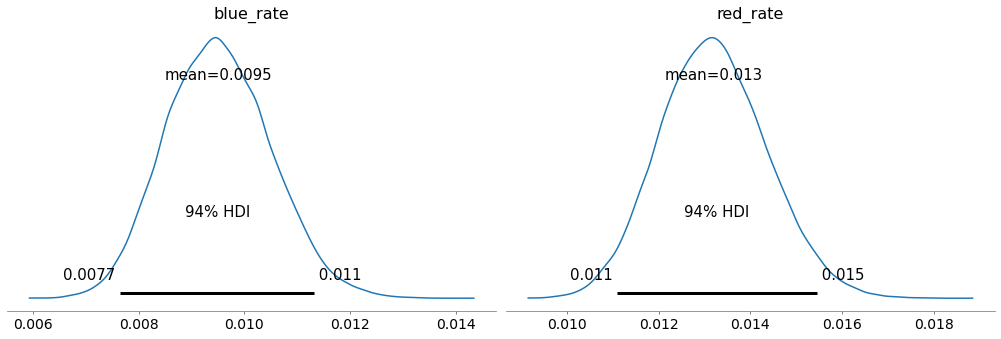

In [64]:
# Байесовская статистика
with pm.Model():
    blue_rate = pm.Beta('blue_rate', 1, 1)
    red_rate = pm.Beta('red_rate', 1, 1)

    blue_obs = pm.Bernoulli('blue_obs', blue_rate, observed=blue_conversions)
    red_obs = pm.Bernoulli('red_obs', red_rate, observed=red_conversions)

    trace = pm.sample(return_inferencedata=True, draws=10000)

# Посмотрим на графики распределения средних конверсий
az.plot_posterior(trace)

# Найдем вероятность превосходства красного варианта над синим
blue_rate_samples = trace.posterior['blue_rate'].values
red_rate_samples = trace.posterior['red_rate'].values
print(f'Probability that red is better: {(red_rate_samples > blue_rate_samples).mean():.1%}.')

In [65]:
# Теперь применим наш способ подсчета вероятности превосходства
alphas = (blue_conversions.sum(), red_conversions.sum())
betas = (blue_conversions.shape[0] - blue_conversions.sum(),
         red_conversions.shape[0] - red_conversions.sum())
print(f"Probability that red is better: {100 * np.round(1 - calc_prob_between(alphas, betas), 3)}%")

Probability that red is better: 99.4%


***Теперь будем сэмплировать распределения (изначально тестовый вариант выигрывает) и смотреть на
вероятности превосходства***

Будем фиксировать

In [81]:
prob_super_list = []
p1_control = np.round(np.linspace(0.01, 0.5, 3000), 3)
# mde_test_effect = np.round(np.linspace(0.01, 0.15, 100), 3)
mde_test_effect = [0]
result_experiments_df = pd.DataFrame(index=pd.MultiIndex.from_product(
                                     [p1_control, mde_test_effect],
                                     names=["p1_control", "mde_test_effect"]),
                                     columns=['probability_superiority',
                                              'size'])
def bayes_results(*index):
    p1_control, mde_test_effect = index
    np.random.seed(round(np.random.random() * 100))
    # size = get_size_zratio(p1_control, (1 + mde_test_effect) * p1_control, alpha=0.01, beta=0.01)
    size = 10000
    data_control = np.random.binomial(1, p=p1_control, size=size)
    data_test = np.random.binomial(1, p=(1 + mde_test_effect) * p1_control, size=size)
    alphas = (data_control.sum(), data_test.sum())
    betas = (size - data_control.sum(), size - data_test.sum())
    return 1 - calc_prob_between(alphas, betas), size
results_all = Parallel(n_jobs=-1)(
                             delayed(bayes_results)(*index)
                             for index, row in tqdm(result_experiments_df.iterrows())
                             )
i = 0
for index, row in result_experiments_df.iterrows():
    result_experiments_df.loc[index, "probability_superiority"] = results_all[i][0]
    result_experiments_df.loc[index, "size"] = results_all[i][1]
    i += 1

0it [00:00, ?it/s]

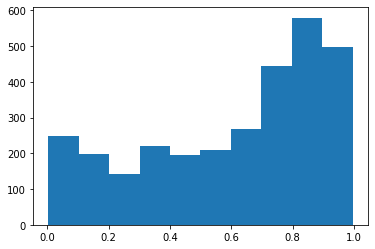

In [82]:
import matplotlib.pyplot as plt
plt.hist(result_experiments_df['probability_superiority'].values);

In [66]:
result_experiments_df['probability_superiority']

p1_control  mde_test_effect
0.010       0                  NaN
            0                  NaN
            0                  NaN
            0                  NaN
0.011       0                  NaN
                              ... 
0.499       0                  NaN
0.500       0                  NaN
            0                  NaN
            0                  NaN
            0                  NaN
Name: probability_superiority, Length: 3000, dtype: object

In [71]:
(result_experiments_df['probability_superiority'] > 0.5).sum()


1747

  0%|          | 0/1000 [00:00<?, ?it/s]

113


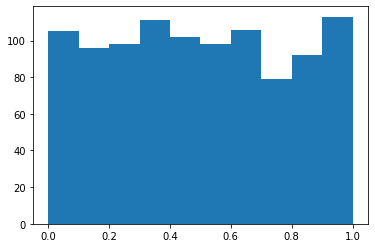

In [8]:
size = 10000
calc_prob_superiority_test = []
for i in tqdm(range(1000)):
    np.random.seed(i)
    data_control = np.random.binomial(1, 0.4, size=size)
    data_test = np.random.binomial(1, 0.4, size=size)
    alphas = (data_control.sum(), data_test.sum())
    betas = (size - data_control.sum(), size - data_test.sum())
    calc_prob_superiority_test.append(1 - calc_prob_between(alphas, betas))

plt.hist(calc_prob_superiority_test);
print(np.sum(np.array(calc_prob_superiority_test) > 0.9))

25136


  0%|          | 0/1000 [00:00<?, ?it/s]

836


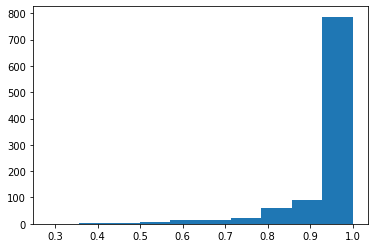

In [23]:
size = round(get_size_zratio(0.4, 0.41, 0.01, 0.01) / 2)
print(size)
calc_prob_superiority_test = []
for i in tqdm(range(1000)):
    np.random.seed(i)
    data_control = np.random.binomial(1, 0.4, size=size)
    data_test = np.random.binomial(1, 0.41, size=size)
    alphas = (data_control.sum(), data_test.sum())
    betas = (size - data_control.sum(), size - data_test.sum())
    calc_prob_superiority_test.append(1 - calc_prob_between(alphas, betas))

plt.hist(calc_prob_superiority_test);
print(np.sum(np.array(calc_prob_superiority_test) > 0.9))

37823

In [ ]:
# 565 раз выявил эффект при вероятности в 90%


*** abyes ***

Method = analytic
Decision Rule = rope
Alpha = 0.95
Rope = (-0.01, 0.01)
Decision Variable = lift

Result is inconclusive.



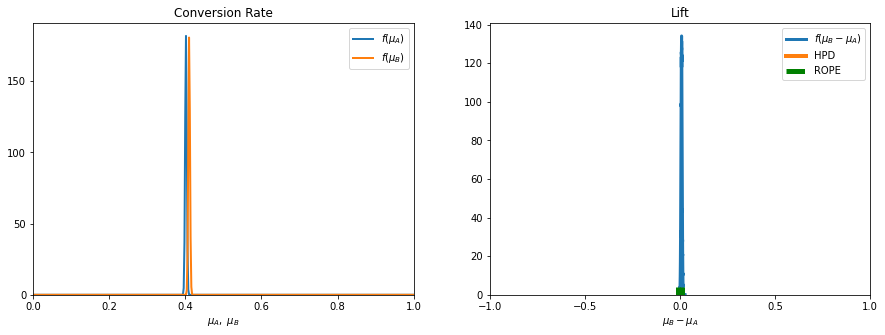

nan

In [85]:
import abyes as ab
exp = ab.AbExp(method='analytic', decision_var = 'lift',
               rule='rope', rope=(-0.01,0.01), alpha=0.95, plot=True)
exp.experiment(data)


*** abyes ***

Method = analytic
Decision Rule = loss
Threshold of Caring = 0.01
Decision Variable = lift

* Result is conclusive: A and B variants are effectively equivalent!



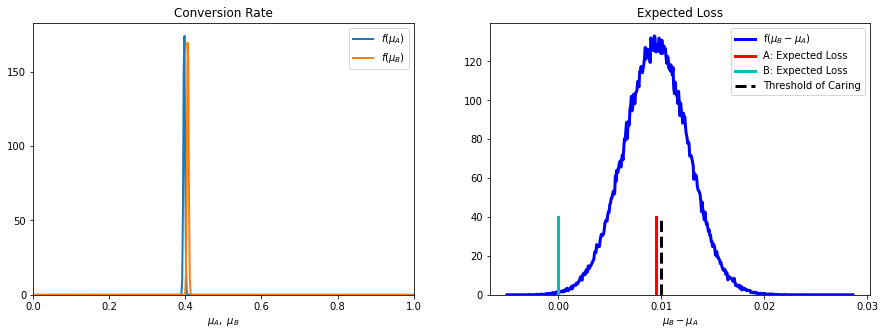

0

In [89]:
exp = ab.AbExp(method='analytic', decision_var = 'lift',
               rule='loss', toc=0.01, plot=True)
exp.experiment(data)

In [ ]:
exp = ab.AbExp(method='mcmc', decision_var = 'es',
               rule='rope', alpha=0.95, plot=True)
exp.experiment(data)

/home/igor/Appbooster/proba.ai/venv/lib/python3.9/site-packages/abyes/ab_exp.py:190: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(self.iterations, step=step, start=start)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [muB]
>Slice: [muA]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 37 seconds.


/home/igor/Appbooster/proba.ai/venv/lib/python3.9/site-packages/abyes/ab_exp.py:190: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(self.iterations, step=step, start=start)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [muB]
>Slice: [muA]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.



Result is conclusive: B variant is winner!


Result is conclusive: B variant is winner!





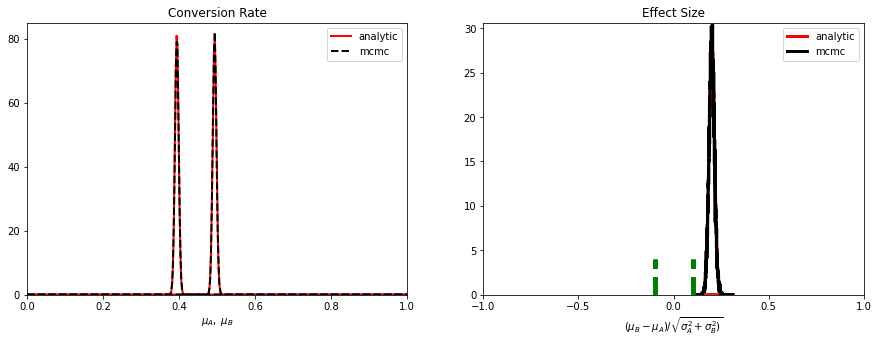

[1, 1]

In [77]:
exp = ab.AbExp(method='compare', decision_var = 'es', plot=True)
exp.experiment(data)

In [ ]:
alphas, betas = [334, 338], [1385 - 334, 1385 - 338]
print(calculate_bayesian_probability(2, 10000, 17, alphas, betas))
print(calc_prob_between(alphas, betas))


# PyMC3

np.random.seed(123)
n_experiments = 1000
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)

with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start, chains=15, cores=4)


burnin = 100
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta': theta_real})
pm.plot_posterior(chain)



mu1 = 82
mu2 = 78
var1 = mu1 * (1 - 0.307)
var2 = mu2 * (1 - 0.274)

cohens = (mu1 - mu2) / np.sqrt((var1 + var2) / 2)
stats.beta.cdf(x=cohens/np.sqrt(2), a=(82 + 78) / 2, b=(267 + 284)/2)
stats.norm.cdf(x=cohens/np.sqrt(2))


tips = sns.load_dataset('tips')
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes
x = set(tips['day'])

with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(x)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(x)))
    y = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    trace_cg = pm.sample(5000, chains=15, cores=15)
chain_cg = trace_cg[100::]
pm.plot_trace(chain_cg)

pm.sample_ppc()

summar = az.summary(trace_cg)

ppc = pm.sample_posterior_predictive(trace_cg, samples=1000,
                                     model=comparing_groups)

az.ppc